# Solving the Inventory Model

We solve the inventory model discussed in the lecture slides using VFI.

We will use the following imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geom
from collections import namedtuple
from numba import njit, int32

We also use the `successive_approx` function, as defined below.

In [2]:
def successive_approx(T,                     # Operator (callable)
                      x_0,                   # Initial condition
                      tolerance=1e-6,        # Error tolerance
                      max_iter=10_000,       # Max iteration bound
                      print_step=25,         # Print at multiples
                      verbose=False):        
    x = x_0
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = np.max(np.abs(x_new - x))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x

## Primitives and functions

To store our model parameters we use a namedtuple.  Here we define the namedtuple and a function to create instances, with default values

In [13]:
Model = namedtuple('Model', ('β', 'K', 'c', 'κ', 'p', 'ϕ'))

In [14]:
def create_inventory_model(β=0.98,     # discount factor
                           K=40,       # maximum inventory
                           c=0.2, κ=2, # cost paramters
                           p=0.6):     # demand parameter
    
    @njit
    def ϕ(d):
        "Geometric distribution on d = 0, 1, 2,... with parameter p."
        return (1 - p)**d * p          

    return Model(β=β, K=K, c=c, κ=κ, p=p, ϕ=ϕ)

The next function is the unmaximized right-hand side of the Bellman equation, which is

$$ 
    r(x, a) + \beta \sum_d v[ F(x, a, d) ] \phi(d) 
    = \text{ profit } + \beta \text{ continuation value}
$$

In [15]:
@njit
def B(x, a, v, model, d_max=100):
    "The function B(x, a, v)"
    β, K, c, κ, p, ϕ = model
    profit = sum([min(x, d)*ϕ(d) for d in range(d_max)]) - c * a - κ * (a > 0)
    continuation_value = sum([v[max(x - d, 0) + a]*ϕ(d) for d in range(d_max)])
    return profit + β * continuation_value

Now we introduce the Bellman operator.

In [16]:
@njit
def T(v, model):
    "The Bellman operator."
    β, K, c, κ, p, ϕ = model
    new_v = np.empty_like(v)
    for x in range(K + 1):
        Γx = range(K - x + 1) 
        max_val = - np.inf
        for a in Γx:
            val = B(x, a, v, model)
            if val > max_val:
                max_val = val
        new_v[x] = max_val
    return new_v

We need a function that computes $v$-greedy policies from any given $v$.

In [17]:
@njit
def get_greedy(v, model):
    β, K, c, κ, p, ϕ  = model
    σ_star = np.empty_like(v, dtype=int32)
    for x in range(K + 1):
        Γx = range(K - x + 1) 
        max_val = - np.inf
        arg_max = 0
        for a in Γx:
            val = B(x, a, v, model)
            if val > max_val:
                max_val = val
                arg_max = a
        σ_star[x] = arg_max
    return σ_star

The function below applies value function iteration to solve the model.

In [18]:
def vfi(v_init, model):
    v_star = successive_approx(lambda v: T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star

## Tests and calculations

Let's put these functions to work:

In [19]:
# Create an instance of the model and solve it
model = create_inventory_model()

In [20]:
β, K, c, κ, p, ϕ = model
v_init = np.zeros(K + 1)

Here we compute the optimal policy and value function using VFI.

In [21]:
v_star, σ_star = vfi(v_init, model)

First we will look at the policy and value functions.

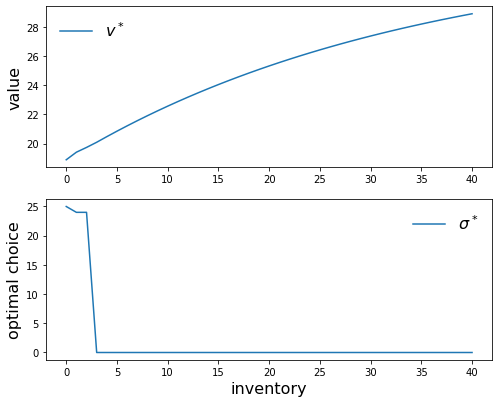

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6.5))
fontsize=16

ax = axes[0]
ax.plot(range(K + 1), v_star, label="$v^*$")
ax.set_ylabel("value", fontsize=fontsize)
ax.legend(fontsize=fontsize, frameon=False)

ax = axes[1]
ax.plot(range(K + 1), σ_star, label="$\\sigma^*$")
ax.set_xlabel("inventory", fontsize=fontsize)
ax.set_ylabel("optimal choice", fontsize=fontsize)
ax.legend(fontsize=fontsize, frameon=False)
plt.show()

Next let's simulate inventories under the optimal policy.

In [23]:
def sim_inventories(ts_length=100, X_init=0):
    "Simulate given the optimal policy."
    G = geom(p)
    X = np.zeros(ts_length, dtype=int)
    X[1] = X_init
    for t in range(ts_length-1):
        D = G.rvs()
        X[t+1] = max(X[t] - D, 0) + σ_star[X[t]]
    return X

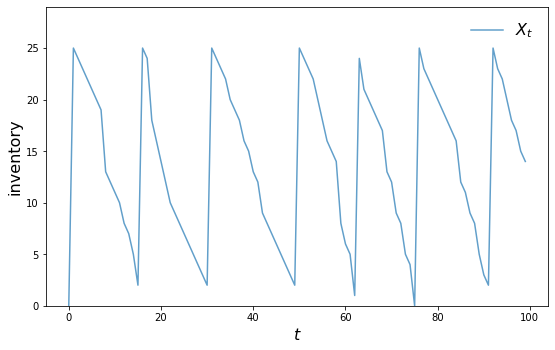

In [24]:
X = sim_inventories()
fig, ax = plt.subplots(figsize=(9, 5.5))
ax.plot(X, label="$X_t$", alpha=0.7)
ax.set_xlabel("$t$", fontsize=fontsize)
ax.set_ylabel("inventory", fontsize=fontsize)
ax.legend(fontsize=fontsize, frameon=False)
ax.set_ylim(0, np.max(X)+4)
plt.show()

In [172]:
σ_star

array([18, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24,
       24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27,
       28, 28, 28, 28, 28, 28, 28], dtype=int32)

In [173]:
len(σ_star)

41